In [2]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Dossiers
base_path = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")

# Lister et trier tous les fichiers .jpg
image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(masks_dir, "*.jpg")))

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de masques : {len(mask_paths)}")

Nombre d'images : 5108
Nombre de masques : 5108


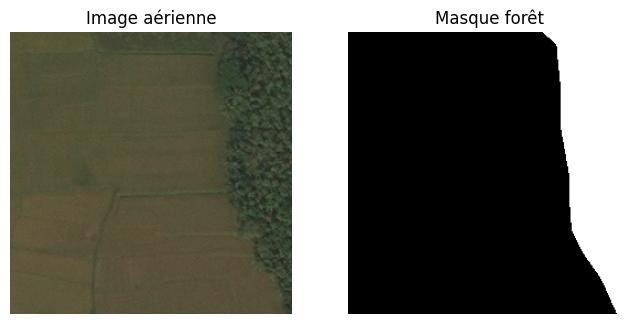

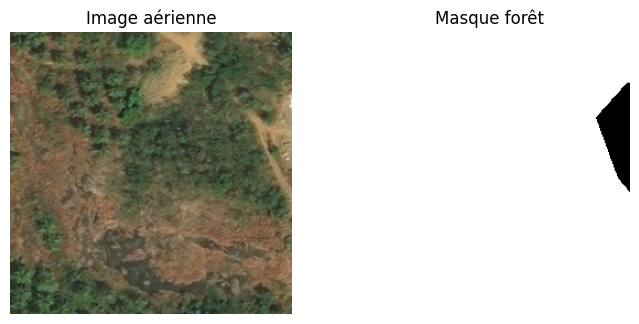

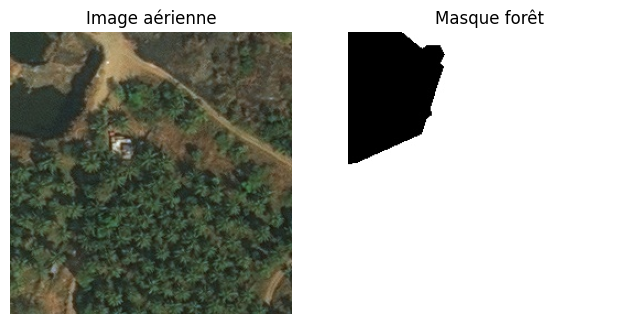

In [4]:
# Choisir 3 exemples aléatoires
for i in [0, 10, 20]:
    img = cv2.imread(image_paths[i])                 # Lire image (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convertir en RGB
    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Masque en niveaux de gris
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque forêt")
    plt.axis("off")
    
    plt.show()

In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = img / 255.0                         
    return img

def preprocess_mask(mask_path, threshold=127):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > threshold, 1, 0)    
    mask = np.expand_dims(mask, axis=-1)      
    return mask

In [6]:

# 70% train
train_size = 0.7
# 20% val
val_size = 0.2 / (1 - train_size)  # proportion de la partie restante (30%)

# Split train / temp (train 70%, temp 30%)
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=1-train_size, random_state=42
)

# Split temp en validation et test (20% et 10% du total)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=1-(val_size), random_state=42
)

print(f"Train: {len(train_img)} images")
print(f"Validation: {len(val_img)} images")
print(f"Test: {len(test_img)} images")

Train: 3575 images
Validation: 1021 images
Test: 512 images


In [20]:
from tensorflow.keras.utils import Sequence
import numpy as np
import albumentations as A
import cv2

# --- Définir les augmentations ---
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_img_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        X, Y = [], []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path)
            
            # Vérification sécurité
            if img is None or mask is None:
                continue
            
            # --- Data augmentation ---
            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            # Normalisation
            img = img.astype(np.float32) / 255.0
            mask = mask.astype(np.float32)
            
            # S'assurer que le masque a bien une dimension canal
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            
            X.append(img)
            Y.append(mask)
        
        # Si batch vide → batch fictif pour éviter crash
        if len(X) == 0:
            X = np.zeros((self.batch_size, 256, 256, 3), dtype=np.float32)
            Y = np.zeros((self.batch_size, 256, 256, 1), dtype=np.float32)
        else:
            X = np.array(X, dtype=np.float32)
            Y = np.array(Y, dtype=np.float32)

        return X, Y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [21]:
X_batch, Y_batch = train_gen[0]
print("Shape X_batch :", X_batch.shape)
print("Shape Y_batch :", Y_batch.shape)

Shape X_batch : (16, 256, 256, 3)
Shape Y_batch : (16, 256, 256, 1)


In [22]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Bloc d'attention ---
from tensorflow.keras import layers

def attention_block(x, g, inter_channel):
    # Réduction des canaux
    theta_x = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)

    # 🔧 Redimensionner g pour correspondre à x
    phi_g = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(phi_g)

    # Somme + activation
    add_xg = layers.Add()([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)

    # Génération de la carte d’attention
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    psi = layers.Activation('sigmoid')(psi)

    # Appliquer la carte d’attention
    out = layers.Multiply()([x, psi])
    return out


# --- Bloc conv standard ---
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# --- Construction du modèle ---
def Attention_UNet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # --- Encodeur ---
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # --- Bottleneck ---
    c5 = conv_block(p4, 1024)

    # --- Décodeur avec attention ---
    g4 = layers.Conv2D(512, (1, 1), padding='same')(c5)
    att4 = attention_block(c4, g4, 512)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, att4])
    c6 = conv_block(u6, 512)

    g3 = layers.Conv2D(256, (1, 1), padding='same')(c6)
    att3 = attention_block(c3, g3, 256)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, att3])
    c7 = conv_block(u7, 256)

    g2 = layers.Conv2D(128, (1, 1), padding='same')(c7)
    att2 = attention_block(c2, g2, 128)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.Concatenate()([u8, att2])
    c8 = conv_block(u8, 128)

    g1 = layers.Conv2D(64, (1, 1), padding='same')(c8)
    att1 = attention_block(c1, g1, 64)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.Concatenate()([u9, att1])
    c9 = conv_block(u9, 64)

    # --- Sortie ---
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs, name="Attention_UNet")
    return model

# --- Créer le modèle ---
model = Attention_UNet(input_shape=(256, 256, 3))
model.summary()


Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_52[0][0] 

 Total params: 32,451,781 (123.79 MB)

 Trainable params: 32,440,005 (123.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [23]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric, dice_coef]
)


In [26]:
print(len(train_img), len(train_mask))
print(len(val_img), len(val_mask))


3575 3575
1021 1021


In [27]:
# --- Entraînement du modèle U-Net ---

# Nombre d'époques
epochs = 30

# Vérification des générateurs
print("Taille du train_gen :", len(train_gen))
print("Taille du val_gen :", len(val_gen))

# --- Callbacks utiles ---
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True)

# --- Compilation du modèle ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Entraînement ---
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# --- Sauvegarde du modèle final ---
model.save("final_unet_model.keras")
print("\n✅ Entraînement terminé et modèle sauvegardé !")


Taille du train_gen : 224
Taille du val_gen : 64
Epoch 1/30
182/224 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7168 - loss: 0.5748

E0000 00:00:1761241999.900742     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761242000.128921     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761242007.847034     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761242008.159904     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761242017.330256     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7193 - loss: 0.5706

E0000 00:00:1761242141.530365     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761242141.769770     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


224/224 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.7193 - loss: 0.5705 - val_accuracy: 0.4013 - val_loss: 11.9728 - learning_rate: 0.0010
Epoch 2/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7642 - loss: 0.5023 - val_accuracy: 0.4104 - val_loss: 2.8268 - learning_rate: 0.0010
Epoch 3/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7779 - loss: 0.4865 - val_accuracy: 0.7704 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 4/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7770 - loss: 0.4850 - val_accuracy: 0.7360 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 5/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7806 - loss: 0.4777 - val_accuracy: 0.7924 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 6/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7887 - loss: 0.4609 - val_accuracy: 0.7513 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 7/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7899 - loss: 0.4590 - val

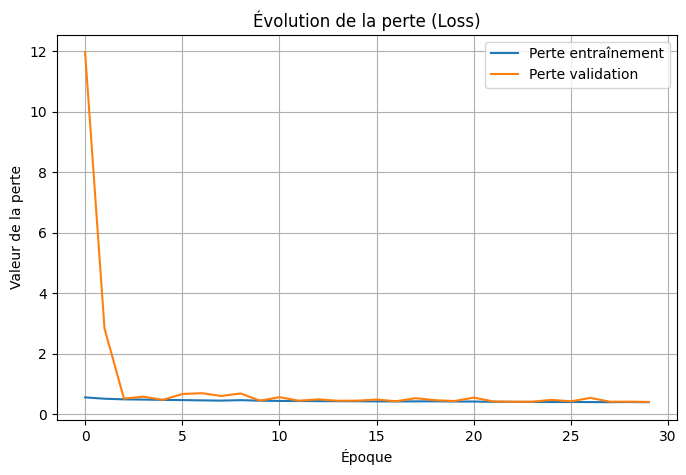

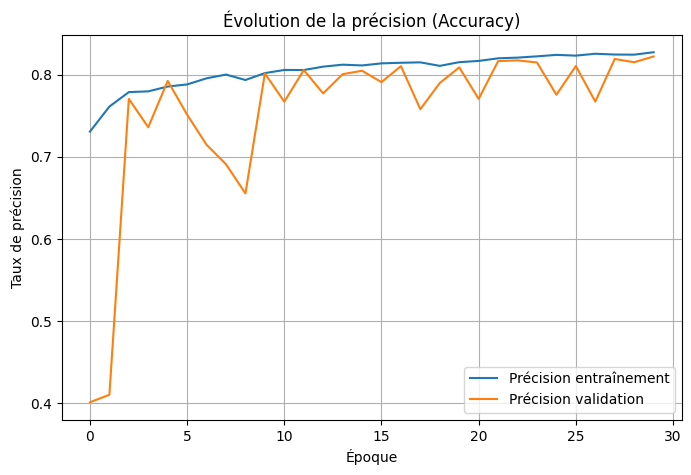

In [28]:
import matplotlib.pyplot as plt

# --- Courbes de perte (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Valeur de la perte")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbes de précision (Accuracy) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque")
plt.ylabel("Taux de précision")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


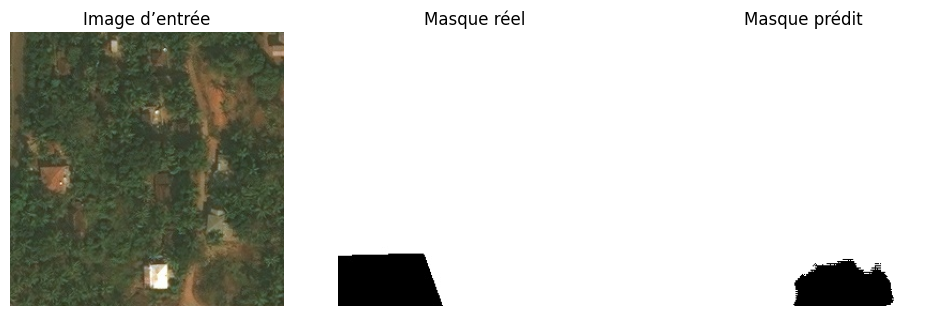

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


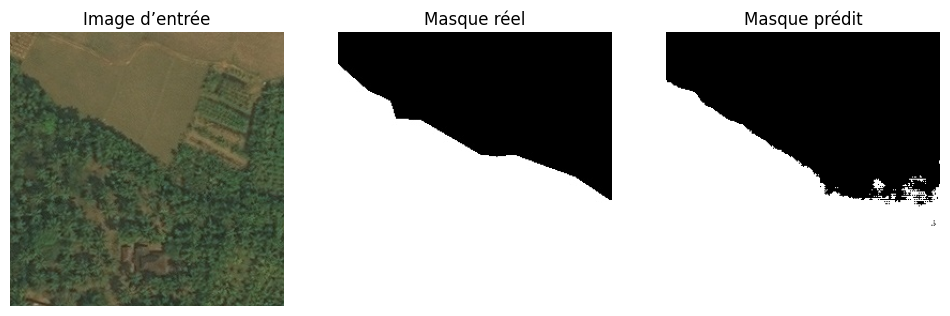

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


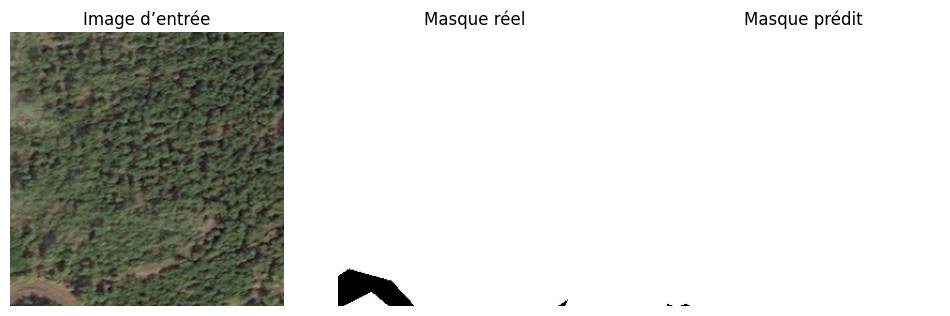

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Fonction pour prédire et afficher ---
def visualize_predictions(model, image_paths, mask_paths, num_samples=3):
    """
    Affiche quelques images avec leur masque réel et le masque prédit par le modèle.
    """
    for i in range(num_samples):
        # Sélectionner une image et son masque
        img_path = image_paths[i]
        mask_path = mask_paths[i]

        # Charger et prétraiter l’image
        img = np.array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = np.array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

        # Ajouter une dimension batch pour la prédiction
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Seuil pour convertir en masque binaire (0 ou 1)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Affichage côte à côte
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image d’entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()

# --- Utilisation avec ton dataset de test ---
visualize_predictions(model, test_img, test_mask, num_samples=3)


In [30]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# ==========================
# 🔹 Fonctions de métriques
# ==========================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# ==========================
# 🔹 Évaluation sur le test set
# ==========================
# Récupération du premier batch test
X_test, Y_test = test_gen[0]
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.float32)

# ==========================
# 🔹 Calcul des métriques
# ==========================
iou = iou_metric(Y_test, Y_pred_bin)
dice = dice_coef(Y_test, Y_pred_bin)
precision = precision_score(Y_test.flatten(), Y_pred_bin.flatten())
recall = recall_score(Y_test.flatten(), Y_pred_bin.flatten())

# Évaluation pour récupérer la loss
eval_result = model.evaluate(X_test, Y_test, verbose=0)
loss_value = eval_result[0] 

# ==========================
# 🔹 Affichage des résultats
# ==========================
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Loss: {loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
IoU (Intersection over Union): 0.8243
Dice Coefficient: 0.9037
Precision: 0.8858
Recall: 0.9223
Loss: 0.3267
